# Analytics Goal: Review Content and Sentimental Score

In [1]:
%%configure -f 
{
"conf":{
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv",
    
        "spark.executor.heartbeatInterval":"10800s",
        "spark.network.timeout":"24h",
    
        "spark.driver.memory": "1G",
        "spark.executor.memory": "1G",
        "spark.executor.cores":"2",

        "spark.app.name":"msds694"
      }
}

In [2]:
sc

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
85,application_1638590815625_0086,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<SparkContext master=yarn appName=msds694>

In [3]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version  
-------------------------- ---------
aws-cfn-bootstrap          2.0      
beautifulsoup4             4.9.3    
boto                       2.49.0   
click                      7.1.2    
docutils                   0.14     
jmespath                   0.10.0   
joblib                     1.0.1    
lockfile                   0.11.0   
lxml                       4.6.3    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pip                        9.0.1    
py-dateutil                2.2      
pystache                   0.5.4    
python-daemon              2.2.3    
python37-sagemaker-pyspark 1.4.1    
pytz                       2021.1   
PyYAML                     5.4.1    
regex                      2021.3.17
setuptools                 28.8.0   
simplejson                 3.2.0    
six                        1.13.0   
tqdm                       4.59.0   
w

In [4]:
# install package
sc.install_pypi_package("vaderSentiment")
sc.install_pypi_package("plotly")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/76/fc/310e16254683c1ed35eeb97386986d6c00bc29df17ce280aed64d55537e9/vaderSentiment-3.3.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/92/96/144f70b972a9c0eabbd4391ef93ccd49d0f2747f4f6a2a2738e99e5adc65/requests-2.26.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/04/a2/d918dcd22354d8958fe113e1a3630137e0fc8b44859ade3063982eacd2a4/idna-3.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/af/f4/524415c0744552cce7d8bf3669af78e8a069514405ea4fcbd0cc44733744/urllib3-1.26.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/47/84/b06f6729fac8108c5fa3e13cde19b0b3de66ba5538c325496dbe39f5ff8e/charset_normalizer-2.0.9-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/37/45/946c02767aabb873146011e665728b680884cd8fe70dde973c640e45b775/certifi-2021.10.8-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org

In [5]:
# data without header
import time
start = time.time()

data_path = "s3://msds694-project-zhipeng/data"
rdd_wholefile = sc.textFile(data_path)
header = rdd_wholefile.take(1)
rdd = rdd_wholefile.filter(lambda x:x != header[0]).map(lambda x:x.split('\t'))
rdd.cache()
rdd.take(1)

print('First time: ', time.time()-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

First time:  6.674628257751465

In [6]:
# Compare time with / without .cache()
start = time.time()

rdd.take(1)

print('Second time: ', time.time()-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Second time:  0.08578276634216309

In [7]:
import re
import string
import nltk
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

ENGLISH_STOP_WORDS = frozenset([
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves"])

def tokenize(text: str):
    """
    Tokenize text and return a non-unique list of tokenized words
    found in the text. Normalize to lowercase, strip punctuation,
    remove stop words, drop words of length < 3, strip digits.
    :param text: raw text
    :param n: need to longer than n word
    :return: a list of token word filter by stopwords
    """
    text = text.lower()
    regex = re.compile(r'[' + string.punctuation + '0-9\r\t\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(" ")
    good_words = [w for w in words if len(w) > 2 if w not in ENGLISH_STOP_WORDS] 
    return good_words

def neg_pos_score(article):
    """
    :param text: a list of dict including article's feature (title, text)
    :return: add sentiment intensity score in range [-1, 1]
    """
    return SIA.polarity_scores(text=article)['compound']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# Review body Sentimental Score of category
def reduce_func(x,y):
    try:
        z = x+y
    except:
        z = x
    return z

def sum_func(x):
    if len(x[1]) == 0:
        return (x[0], 0)
    try:
        score = sum(x[1])/len(x[1])
    except:
        return (x[0], 0)
    return (x[0], sum(x[1])/len(x[1]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
SIA = SentimentIntensityAnalyzer()
rdd_score = rdd.map(lambda x: (x[6], x[13][:200])).map(lambda x: (x[0], [neg_pos_score(x[1])]))
rdd_score = rdd_score.reduceByKey(reduce_func).map(sum_func)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
rdd_score_df = rdd_score.toDF()
rdd_score_df.createOrReplaceTempView("rdd_score_view")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
%%sql -o rdd_score_tab
SELECT * FROM rdd_score_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [35]:
%%local
rdd_score_tab = rdd_score_tab.sort_values(by=['_2'])
rdd_score_tab

Output()

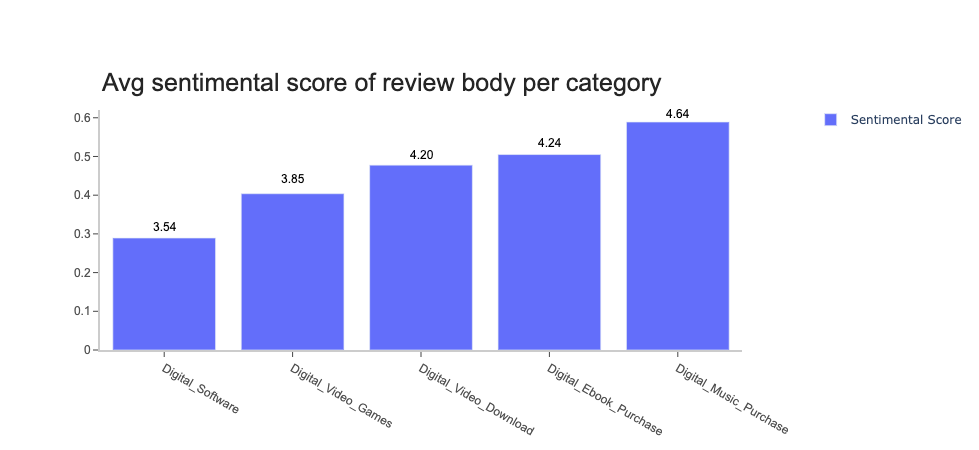

In [41]:
%%local
import plotly
import plotly.graph_objects as go

x = rdd_score_tab['_1']
y = rdd_score_tab['_2']
fig = go.Figure(data=[go.Bar(x=x, y=y, hovertext=x, name='Sentimental Score')])

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    autosize=False,
    margin=dict(
        autoexpand=True,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=True,
    plot_bgcolor='white'
)
annotations = []

#annotation
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Avg sentimental score of review body per category',
                              font=dict(family='Arial',
                                        size=25,
                                        color='rgb(37,37,37)'),
                              showarrow=False))


annotations.append(dict(xref='paper', yref='paper', x=0.9, y=1.02,
                              xanchor='center', yanchor='top',
                              text='4.64',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.7, y=0.9,
                              xanchor='center', yanchor='top',
                              text='4.24',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=0.85,
                              xanchor='center', yanchor='top',
                              text='4.20',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.3, y=0.75,
                              xanchor='center', yanchor='top',
                              text='3.85',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.1, y=0.55,
                              xanchor='center', yanchor='top',
                              text='3.54',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
# Legend
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="top",
    y=1.02,
    xanchor="right",
    x=1.35
))

fig.update_layout(annotations=annotations)
fig.show()

In [29]:
# Review Headline Sentimental Score of category
def reduce_func(x,y):
    try:
        z = x+y
    except:
        z = x
    return z

def sum_func(x):
    if len(x[1]) == 0:
        return (x[0], 0)
    try:
        score = sum(x[1])/len(x[1])
    except:
        return (x[0], 0)
    return (x[0], sum(x[1])/len(x[1]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
SIA = SentimentIntensityAnalyzer()
rdd_score = rdd.map(lambda x: (x[6], x[12])).map(lambda x: (x[0], [neg_pos_score(x[1])]))
rdd_score = rdd_score.reduceByKey(reduce_func).map(sum_func)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
rdd_score_df = rdd_score.toDF()
rdd_score_df.createOrReplaceTempView("rdd_score_view")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
%%sql -o rdd_score_tab
SELECT * FROM rdd_score_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [19]:
%%local
rdd_score_tab = rdd_score_tab.sort_values(by=['_2'])
rdd_score_tab

Output()

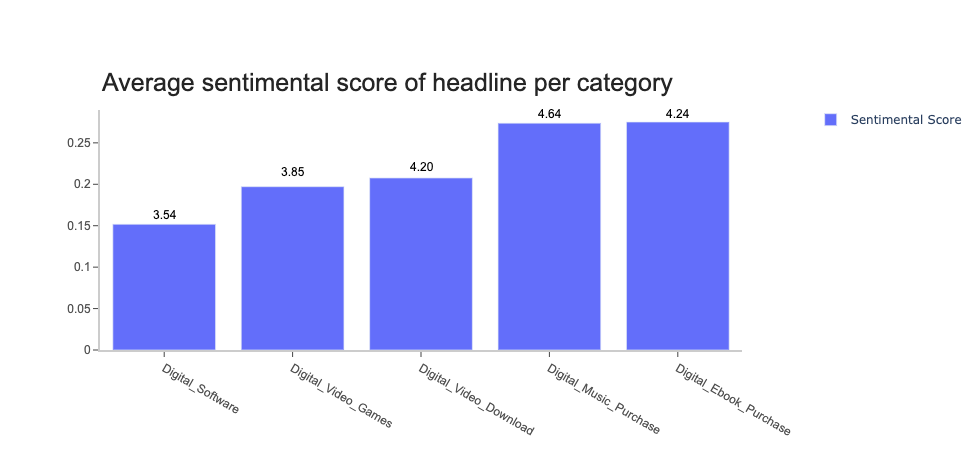

In [30]:
%%local
import plotly
import plotly.graph_objects as go

x = rdd_score_tab['_1']
y = rdd_score_tab['_2']
fig = go.Figure(data=[go.Bar(x=x, y=y, hovertext=x, name='Sentimental Score')])

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    autosize=False,
    margin=dict(
        autoexpand=True,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=True,
    plot_bgcolor='white'
)
annotations = []

#annotation
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Average sentimental score of headline per category',
                              font=dict(family='Arial',
                                        size=25,
                                        color='rgb(37,37,37)'),
                              showarrow=False))


annotations.append(dict(xref='paper', yref='paper', x=0.9, y=1.02,
                              xanchor='center', yanchor='top',
                              text='4.24',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.7, y=1.02,
                              xanchor='center', yanchor='top',
                              text='4.64',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=0.8,
                              xanchor='center', yanchor='top',
                              text='4.20',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.3, y=0.78,
                              xanchor='center', yanchor='top',
                              text='3.85',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.1, y=0.6,
                              xanchor='center', yanchor='top',
                              text='3.54',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
# Legend
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="top",
    y=1.02,
    xanchor="right",
    x=1.35
))

fig.update_layout(annotations=annotations)
fig.show()

In [ ]:
%%local
# import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'retina'
import plotly
import plotly.graph_objects as go

x = rdd_score_tab['_1']
y = rdd_score_tab['_2']

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=x, y=y, 
                             marker_color='lightsalmon',
                             hovertext=x)])
fig.update_layout(xaxis=dict(tickformat="digit"))
fig.show()

In [6]:
# Avg review length of category
rdd_len = rdd.map(lambda x: (x[6], x[13])).map(lambda x: (x[0], [len(x[1])]))
rdd_len = rdd_len.reduceByKey(lambda x,y: x+y).map(lambda x: (x[0], sum(x[1])/len(x[1])))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
rdd_len_df = rdd_len.toDF()
rdd_len_df.createOrReplaceTempView("rdd_len_view")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
%%sql -o rdd_len_tab
SELECT * FROM rdd_len_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [9]:
%%local
rdd_len_tab = rdd_len_tab.sort_values(by=['_2'])
rdd_len_tab

Output()

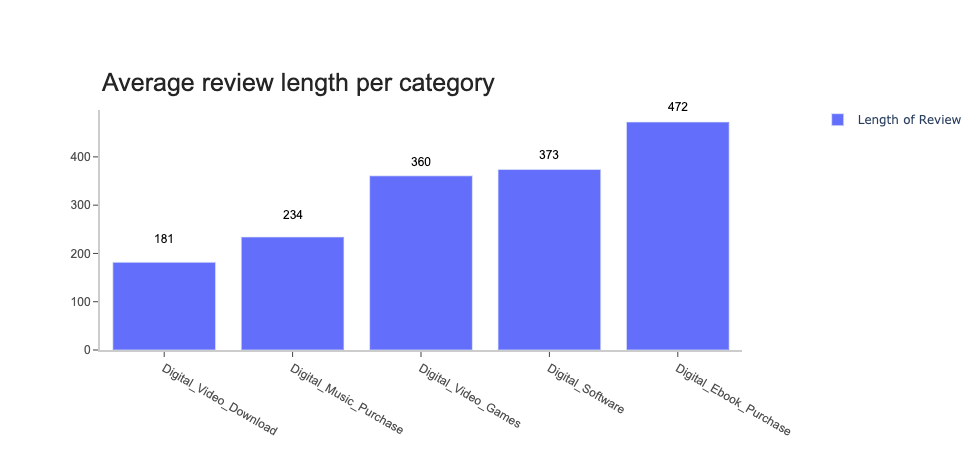

In [46]:
%%local
import plotly
import plotly.graph_objects as go

x = rdd_len_tab['_1']
y = rdd_len_tab['_2']
fig = go.Figure(data=[go.Bar(x=x, y=y, hovertext=x, name='Length of Review')])

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    autosize=False,
    margin=dict(
        autoexpand=True,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=True,
    plot_bgcolor='white'
)
annotations = []

#annotation
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Average review length per category',
                              font=dict(family='Arial',
                                        size=25,
                                        color='rgb(37,37,37)'),
                              showarrow=False))


annotations.append(dict(xref='paper', yref='paper', x=0.9, y=1.05,
                              xanchor='center', yanchor='top',
                              text='472',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.7, y=0.85,
                              xanchor='center', yanchor='top',
                              text='373',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=0.82,
                              xanchor='center', yanchor='top',
                              text='360',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.3, y=0.6,
                              xanchor='center', yanchor='top',
                              text='234',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.1, y=0.5,
                              xanchor='center', yanchor='top',
                              text='181',
                              font=dict(family='Arial',
                                        size=12,
                                        color='black'),
                              showarrow=False))
# Legend
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="top",
    y=1.02,
    xanchor="right",
    x=1.35
))

fig.update_layout(annotations=annotations)
fig.show()

In [7]:
# Avg review length with of year : Execution time:  813.5s
import time
start = time.time()

rdd_year = rdd.map(lambda x: (x[14][:4], x[13])).map(lambda x: (x[0], [len(x[1])]))
rdd_year = rdd_year.reduceByKey(lambda x,y: x+y).map(lambda x: (x[0], sum(x[1])/len(x[1])))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
rdd_year_df = rdd_year.toDF()
rdd_year_df.createOrReplaceTempView("rdd_year_view")
print('Execution time: ', time.time()-start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Execution time:  813.4903481006622

In [14]:
%%sql -o rdd_year_tab
SELECT * FROM rdd_year_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [17]:
%%local
rdd_year_tab = rdd_year_tab.sort_values(by=['_1'])[7:]
rdd_year_tab

Output()

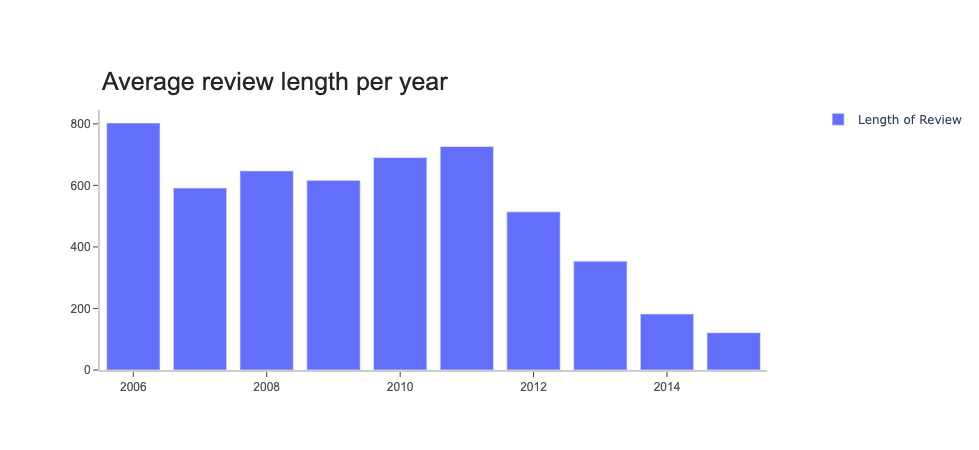

In [19]:
%%local
import plotly
import plotly.graph_objects as go

x = rdd_year_tab['_1']
y = rdd_year_tab['_2']
fig = go.Figure(data=[go.Bar(x=x, y=y, hovertext=x, name='Length of Review')])

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    autosize=False,
    margin=dict(
        autoexpand=True,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=True,
    plot_bgcolor='white'
)
annotations = []

#annotation
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Average review length per year',
                              font=dict(family='Arial',
                                        size=25,
                                        color='rgb(37,37,37)'),
                              showarrow=False))

# Legend
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="top",
    y=1.02,
    xanchor="right",
    x=1.3
))

fig.update_layout(annotations=annotations)
fig.show()

In [47]:
sc.stop()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…